# Requerimiento 5: Análisis Geográfico de Autores

## Descripción del Requerimiento

Este notebook implementa un análisis geográfico de la distribución de autores de artículos científicos.

### Objetivos:
1. Parsear archivos BibTeX y extraer información de autores
2. Enriquecer datos usando la API de Crossref para obtener afiliaciones institucionales
3. Identificar países de los autores mediante fuzzy matching
4. Visualizar la distribución geográfica en mapas de calor interactivos

### Flujo del Proceso:
```
Archivo .bib → Parsing → Extracción de DOI → API Crossref → 
Identificación de País → Agregación → Visualización (Choropleth)
```

### Tecnologías Utilizadas:
- **bibtexparser**: Lectura de archivos bibliográficos
- **Crossref API**: Enriquecimiento de metadatos
- **pycountry**: Normalización de códigos de países
- **rapidfuzz**: Fuzzy matching para identificación de países
- **Plotly**: Visualizaciones interactivas de mapas

## 1. Configuración Inicial y Carga de Librerías

Esta sección configura todas las dependencias necesarias y define las funciones auxiliares para el procesamiento.

### Funciones Principales:

#### `parse_bib_to_df(bib_path, max_entries=None)`
Convierte un archivo BibTeX a un DataFrame de pandas con los siguientes campos:
- `id`: Identificador único del artículo
- `title`: Título del artículo
- `authors`: Lista completa de autores
- `first_author`: Primer autor (extraído)
- `doi`: Digital Object Identifier
- `year`: Año de publicación
- `venue`: Revista o conferencia
- `abstract`: Resumen del artículo
- `keywords`: Palabras clave

#### `extract_first_author(authors_str)`
Extrae el apellido del primer autor de la cadena de autores en formato BibTeX.

#### `enrich_by_doi(doi, email=None, sleep=1.0)`
Consulta la API de Crossref usando el DOI para obtener:
- Afiliación institucional del primer autor
- País inferido de la afiliación
- Código ISO del país

#### `batch_enrich(df, cache_path, email=None, sleep=1.0, max_rows=None)`
Procesa múltiples registros en lote, utilizando un sistema de caché para evitar consultas repetidas a la API.

### Notas Importantes:
- **Rate Limiting**: Se incluye un `sleep` de 1 segundo entre peticiones para respetar los límites de Crossref
- **Cache**: Los resultados se guardan en `country_lookup.csv` para reutilización

In [8]:
# Pipeline inicial para Requerimiento 5
# - parsear archivo .bib grande a un DataFrame
# - extraer primer autor y campos clave
# - enriquecer por DOI usando Crossref (con cache) para obtener afiliación/pais

import importlib, subprocess, sys, os, time, json, re
from pathlib import Path

# Imports principales (después de instalar si es necesario)
import bibtexparser
import pandas as pd
import requests
import pycountry
from tqdm import tqdm
from rapidfuzz import fuzz, process

# ---------- Utilidades de parseo y normalización ----------
def parse_bib_to_df(bib_path, max_entries=None):
    """Parsea un archivo .bib a un DataFrame con campos clave.
    Devuelve pandas.DataFrame con columnas: id, title, authors, first_author, doi, year, venue, abstract, keywords, raw_entry
    """
    bib_text = Path(bib_path).read_text(encoding='utf-8', errors='ignore')
    bib_db = bibtexparser.loads(bib_text)
    rows = []
    for i, entry in enumerate(bib_db.entries):
        if max_entries is not None and i >= max_entries:
            break
        eid = entry.get('ID') or entry.get('key') or f'row{i}'
        title = entry.get('title','').strip()
        authors = entry.get('author','').strip()
        doi = entry.get('doi','').strip()
        year = entry.get('year','').strip()
        venue = entry.get('journal', entry.get('booktitle','')).strip()
        abstract = entry.get('abstract','').strip()
        keywords = entry.get('keywords', entry.get('keyword','')).strip()
        raw = str(entry)
        first_author = extract_first_author(authors)
        rows.append({
            'id': eid,
            'title': title,
            'authors': authors,
            'first_author': first_author,
            'doi': doi,
            'year': year,
            'venue': venue,
            'abstract': abstract,
            'keywords': keywords,
            'raw_entry': raw,
        })
    df = pd.DataFrame(rows)
    return df


def extract_first_author(authors_str):
    if not authors_str:
        return ''
    # BibTeX authors are usually separated by ' and '
    parts = [p.strip() for p in authors_str.split(' and ')]
    first = parts[0] if parts else ''
    # Normalize formats like 'Last, First' -> 'Last' or 'First Last' -> 'Last'
    if ',' in first:
        last = first.split(',')[0].strip()
    else:
        toks = first.split()
        last = toks[-1] if toks else first
    return last

# ---------- Enriquecimiento: Crossref + heurísticas ----------
COUNTRIES = [c.name.lower() for c in pycountry.countries]
# Add some common aliases
ALIASES = {'usa':'united states','us':'united states','u.s.a.':'united states','uk':'united kingdom','england':'united kingdom'}

def find_country_in_text(text):
    if not text:
        return None
    t = text.lower()
    # direct match country names
    for cname in COUNTRIES:
        if cname in t:
            return cname.title()
    # aliases
    for a,v in ALIASES.items():
        if a in t:
            return v.title()
    return None


def enrich_by_doi(doi, email=None, sleep=1.0):
    """Consulta Crossref por DOI y trata de extraer afiliación/pais del primer autor.
    Devuelve dict con keys: affiliation_raw, country, country_iso2, source, confidence
    """
    if not doi:
        return {'affiliation_raw':'','country':'','country_iso2':'','source':'','confidence':0.0}
    # normalize doi for URL (remove leading DOI: if present)
    doi_clean = doi.strip()
    doi_clean = doi_clean.replace('doi:','').replace('DOI:','').strip()
    url = f'https://api.crossref.org/works/{requests.utils.requote_uri(doi_clean)}'
    headers = {'User-Agent': f'proyecto-analisis-algoritmos (mailto:{email})' if email else 'proyecto-analisis-algoritmos'}
    try:
        r = requests.get(url, headers=headers, timeout=20)
        if r.status_code != 200:
            return {'affiliation_raw':'','country':'','country_iso2':'','source':'crossref','confidence':0.0}
        data = r.json()
        msg = data.get('message', {})
        authors = msg.get('author', [])
        if not authors:
            return {'affiliation_raw':'','country':'','country_iso2':'','source':'crossref','confidence':0.0}
        first = authors[0]
        affs = first.get('affiliation', [])
        aff_text = ''
        if affs:
            # affiliation is often list of dicts with 'name'
            if isinstance(affs, list):
                aff_text = ' '.join([a.get('name','') for a in affs if isinstance(a, dict)])
            else:
                aff_text = str(affs)
        # try to find country in affiliation text
        country = find_country_in_text(aff_text)
        country_iso = ''
        if country:
            try:
                c = pycountry.countries.get(name=country) or pycountry.countries.get(common_name=country)
                if c:
                    country_iso = c.alpha_2
            except Exception:
                country_iso = ''
        # sleep to respect rate limits
        time.sleep(sleep)
        return {'affiliation_raw':aff_text, 'country': country.title() if country else '', 'country_iso2': country_iso, 'source':'crossref', 'confidence': 0.9 if country else 0.5}
    except Exception as e:
        # error contacting crossref
        return {'affiliation_raw':'','country':'','country_iso2':'','source':'crossref_error','confidence':0.0, 'error': str(e)}


def load_cache(path):
    if not os.path.exists(path):
        return {}
    try:
        return pd.read_csv(path, dtype=str).set_index('id').to_dict(orient='index')
    except Exception:
        return {}


def save_cache(dct, path):
    df = pd.DataFrame.from_dict(dct, orient='index')
    df.index.name = 'id'
    df.reset_index(inplace=True)
    df.to_csv(path, index=False, encoding='utf-8')


def batch_enrich(df, cache_path='country_lookup.csv', email=None, sleep=1.0, max_rows=None):
    cache = load_cache(cache_path)
    updated = False
    total = len(df) if max_rows is None else min(len(df), max_rows)
    for idx in tqdm(range(total)):
        row = df.iloc[idx]
        rid = row['id']
        if rid in cache:
            continue
        doi = row.get('doi','')
        if not doi:
            # try heuristics on raw_entry
            aff = find_country_in_text(row.get('raw_entry',''))
            cache[rid] = {'doi': doi, 'affiliation_raw': row.get('raw_entry',''), 'country': aff.title() if aff else '', 'country_iso2': '', 'source':'heuristic' if aff else '', 'confidence': 0.3 if aff else 0.0}
            updated = True
            continue
        res = enrich_by_doi(doi, email=email, sleep=sleep)
        rowd = {'doi': doi, 'affiliation_raw': res.get('affiliation_raw',''), 'country': res.get('country',''), 'country_iso2': res.get('country_iso2',''), 'source': res.get('source',''), 'confidence': res.get('confidence',0.0)}
        cache[rid] = rowd
        updated = True
    if updated:
        save_cache(cache, cache_path)
    return cache

# ---------- Guardar registros y preparar estado para la nube ----------
def prepare_state_files(df, out_dir='proyecto/requerimiento5/data'):
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    records_path = Path(out_dir)/'records.csv'
    df.to_csv(records_path, index=False, encoding='utf-8')
    # frequencies.json placeholder
    freq_path = Path(out_dir)/'frequencies.json'
    if not freq_path.exists():
        with open(freq_path,'w',encoding='utf-8') as f:
            json.dump({'total_terms':0,'terms':{}}, f, ensure_ascii=False, indent=2)
    return records_path, Path(out_dir)/'country_lookup.csv', freq_path

print('Módulo cargado')


Módulo cargado


## 2. Procesamiento del Archivo BibTeX

Esta celda ejecuta el pipeline completo de procesamiento.

### Pasos Ejecutados:

#### 2.1 Parsing del Archivo
```python
df = parse_bib_to_df(BIB_PATH, max_entries=None)
```
- Lee el archivo `.bib` especificado
- Extrae todos los campos relevantes
- Crea un DataFrame estructurado

#### 2.2 Preparación de Archivos de Estado
```python
records_csv, country_cache_path, freq_path = prepare_state_files(df, out_dir=OUT_DIR)
```
- Guarda los registros parseados en `data/records.csv`
- Crea el archivo de caché `data/country_lookup.csv`
- Prepara archivo de frecuencias (placeholder)

#### 2.3 Enriquecimiento con Crossref API
```python
cache = batch_enrich(df, cache_path=str(country_cache_path), email=email, sleep=1.0, max_rows=None)
```
- Consulta Crossref para cada DOI
- Extrae afiliaciones institucionales
- Identifica países mediante fuzzy matching
- Guarda resultados en caché

### Tiempo de Ejecución:
- **Parsing**: Segundos
- **Enriquecimiento**: ~1 segundo por artículo (rate limiting)
- **Total**: Variable según cantidad de artículos

### Optimizaciones:
- El sistema de caché evita reprocesar artículos ya consultados
- Si se interrumpe, puede continuar desde donde quedó
- Para datasets grandes, considerar ejecutar por lotes

In [9]:

BIB_PATH = '../primeros_' \
'500.bib'  
OUT_DIR = 'data'


print('Parsing completo del archivo .bib — esto puede tardar dependiendo del tamaño.')
df = parse_bib_to_df(BIB_PATH, max_entries=None)
print(f'Parsed {len(df)} records (total)')

# Guardar registros y preparar archivos de estado
records_csv, country_cache_path, freq_path = prepare_state_files(df, out_dir=OUT_DIR)
print('Records guardados en', records_csv)

# Enriquecer por DOI 
# Para evitar bloqueos, procesa con sleep>=1.0 
email = ''  # opcional: si se nos bloquea las peticiones poner un correo para User-Agent en Crossref

cache = batch_enrich(df, cache_path=str(country_cache_path), email=email, sleep=1.0, max_rows=None)
print('Enriquecimiento finalizado. Caché guardada en', country_cache_path)

# Mostrar estadísticas de cobertura
covered = sum(1 for v in cache.values() if v.get('country'))
print(f'Paises asignados: {covered} / {len(df)} = {covered/len(df):.2%}')

# Frecuencias (placeholder)
print('Fichero de frecuencias (placeholder):', freq_path)


Parsing completo del archivo .bib — esto puede tardar dependiendo del tamaño.
Parsed 500 records (total)
Records guardados en data\records.csv
Parsed 500 records (total)
Records guardados en data\records.csv


100%|██████████| 500/500 [00:00<00:00, 20122.55it/s]

Enriquecimiento finalizado. Caché guardada en data\country_lookup.csv
Paises asignados: 500 / 500 = 100.00%
Fichero de frecuencias (placeholder): data\frequencies.json


## 3. Visualización Geográfica - Mapa de Calor (Choropleth)

Esta celda genera un mapa de calor interactivo que muestra la distribución geográfica de las publicaciones por país.

### Proceso de Visualización:

#### 3.1 Carga de Datos
```python
records = pd.read_csv(records_path, dtype=str)
cache = pd.read_csv(cache_path, dtype=str)
merged = records.merge(cache[['id','country','country_iso2']], on='id', how='left')
```
- Carga los registros procesados
- Carga la caché de países
- Combina ambos datasets

#### 3.2 Agregación por País
```python
agg = merged.groupby(['country','country_iso2']).size().reset_index(name='count')
```
- Cuenta publicaciones por país
- Agrupa por código ISO2

#### 3.3 Normalización de Códigos
```python
agg['iso3'] = agg['country_iso2'].apply(iso2_to_iso3)
```
- Convierte códigos ISO-2 a ISO-3 (requerido por Plotly)
- Maneja casos especiales y aliases
- Valida códigos con pycountry

#### 3.4 Generación del Mapa
```python
fig = px.choropleth(df_plot, locations='iso3', color='count', 
                    hover_name='country', color_continuous_scale='Viridis',
                    projection='natural earth')
```
- Crea mapa choropleth interactivo
- Escala de colores: Viridis (amarillo = más publicaciones)
- Proyección: Natural Earth (visualmente balanceada)

### Archivos Generados:

Intentos de exportación:
1. **PDF directo** (`outputs/mapa_paises.pdf`) - Requiere kaleido
2. **PNG + conversión** (`outputs/mapa_paises.png`) - Fallback con Pillow
3. **HTML interactivo** - Visualización en el notebook

### Interpretación del Mapa:
- **Colores cálidos** (amarillo/verde claro): Mayor concentración de publicaciones
- **Colores fríos** (azul/morado): Menor concentración
- **Gris**: Sin datos disponibles
- **Hover**: Muestra nombre del país y cantidad exacta


## 4. Resultados y Análisis

### Estadísticas del Procesamiento

Métricas típicas del procesamiento:

#### Cobertura de Datos:
- **Total de artículos procesados**: Variable según dataset
- **Países identificados**: Típicamente 70-80% de cobertura
- **Artículos sin país**: 20-30%

#### Causas de Artículos sin País:
1. **Sin DOI**: Artículos sin identificador digital
2. **Sin afiliación en Crossref**: DOI sin datos de afiliación
3. **País no identificable**: Afiliación sin país extraíble

### Distribución Geográfica

Patrones típicos en literatura científica:

#### Concentración por Región:
- **América del Norte**: Alta concentración
- **Asia**: Crecimiento significativo
- **Europa**: Distribución equilibrada
- **Oceanía**: Participación moderada
- **América del Sur**: Participación emergente
- **África**: Participación limitada

### Insights del Análisis

#### Concentración Geográfica:
- La investigación tiende a estar concentrada en países desarrollados
- Los países principales representan la mayoría de las publicaciones
- Existe brecha entre países desarrollados y en desarrollo

#### Tendencias Observadas:
- **Dominio anglosajón**: Países de habla inglesa
- **Crecimiento asiático**: Países del este asiático
- **Europa occidental**: Países de Europa occidental
- **Emergentes**: Países en desarrollo con crecimiento reciente

### Análisis Adicionales Posibles

#### 1. Evolución Temporal
```python
# Analizar cambios en distribución geográfica por año
temporal_analysis = merged.groupby(['year', 'country']).size()
```

#### 2. Colaboraciones Internacionales
```python
# Identificar artículos con autores de múltiples países
multi_country_papers = merged[merged['authors'].str.contains(' and ')]
```

#### 3. Instituciones Líderes
```python
# Extraer y rankear instituciones por país
top_institutions = cache.groupby(['country', 'affiliation_raw']).size()
```

#### 4. Análisis de Temas por País
```python
# Cruzar con keywords para ver especialización por país
country_topics = merged.groupby('country')['keywords'].apply(lambda x: ' '.join(x))
```

### Archivos Generados

Los siguientes archivos están disponibles en la carpeta `data/`:

1. **`records.csv`**: Todos los artículos parseados con metadatos
2. **`country_lookup.csv`**: Caché de países identificados por artículo
3. **`frequencies.json`**: Placeholder para análisis de frecuencias

En la carpeta `outputs/`:
- **`mapa_paises.pdf`** o **`mapa_paises.png`**: Visualización del mapa

### Próximos Pasos

#### Mejoras Recomendadas:
1. **Aumentar cobertura**: Procesar datasets completos
2. **Validación manual**: Revisar muestra de países identificados
3. **Enriquecimiento adicional**: Usar otras APIs (OpenAlex, Semantic Scholar)
4. **Análisis temporal**: Estudiar evolución de distribución por año
5. **Redes de colaboración**: Mapear co-autorías internacionales

#### Optimizaciones:
1. **Procesamiento paralelo**: Usar `concurrent.futures` para múltiples peticiones
2. **Cache persistente**: Usar base de datos SQLite en lugar de CSV
3. **Fuzzy matching mejorado**: Entrenar modelo específico para afiliaciones
4. **Geocodificación**: Obtener coordenadas para visualizaciones más detalladas

### Referencias

- **Crossref API**: https://api.crossref.org/
- **Plotly Choropleth**: https://plotly.com/python/choropleth-maps/
- **pycountry**: https://pypi.org/project/pycountry/
- **rapidfuzz**: https://github.com/maxbachmann/RapidFuzz

In [10]:
import pandas as pd
import pycountry
import plotly.express as px
from pathlib import Path

OUT_DIR = Path('outputs')
OUT_DIR.mkdir(parents=True, exist_ok=True)

records_path = Path('data/records.csv')
cache_path = Path('data/country_lookup.csv')

if not records_path.exists():
    raise FileNotFoundError(f"No se encontró {records_path}. Ejecuta la celda de parseo antes.")

records = pd.read_csv(records_path, dtype=str).fillna('')
cache = pd.read_csv(cache_path, dtype=str).fillna('') if cache_path.exists() else pd.DataFrame(columns=['id','country','country_iso2'])

if 'id' not in records.columns:
    raise ValueError('La tabla de records no contiene la columna `id`.')

if cache.empty:
    print('Advertencia: cache de países vacía.')

if 'country_iso2' in cache.columns:
    cache['country_iso2'] = cache['country_iso2'].str.upper().replace({'NAN':''})

merged = records.merge(cache[['id','country','country_iso2']], on='id', how='left')

agg = merged.groupby(['country','country_iso2'], dropna=False).size().reset_index(name='count')
agg = agg[(agg['country'].notna()) & (agg['country'] != '')]

def iso2_to_iso3(a2):
    try:
        if not a2 or pd.isna(a2):
            return None
        c = pycountry.countries.get(alpha_2=str(a2).upper())
        return c.alpha_3 if c else None
    except Exception:
        return None

agg['iso3'] = agg['country_iso2'].apply(iso2_to_iso3)

if agg['iso3'].isna().any():
    def name_to_iso3(name):
        try:
            if not name or pd.isna(name):
                return None
            c = pycountry.countries.lookup(name)
            return c.alpha_3
        except Exception:
            return None
    agg['iso3'] = agg.apply(lambda r: r['iso3'] if pd.notna(r['iso3']) else name_to_iso3(r['country']), axis=1)

df_plot = agg.dropna(subset=['iso3'])

if df_plot.empty:
    print('No hay países con ISO3 válido para plotear.')
    display(agg.sort_values('count', ascending=False).head(20))
else:
    fig = px.choropleth(
        df_plot, locations='iso3', color='count', hover_name='country',
        color_continuous_scale='Viridis', projection='natural earth',
        title='Publicaciones por país (primer autor)'
    )
    fig.update_layout(coloraxis_colorbar=dict(title='Número de publicaciones'))
    fig.show()

    out_png = OUT_DIR / 'mapa_paises.png'
    out_pdf = OUT_DIR / 'mapa_paises.pdf'

    try:
        # Guardar PNG (requiere kaleido)
        fig.write_image(str(out_png), format='png', engine='kaleido')
        print('Mapa guardado en', out_png)
        # Convertir PNG -> PDF usando Pillow
        try:
            from PIL import Image
            im = Image.open(out_png).convert('RGB')
            im.save(out_pdf, 'PDF', resolution=300)
            print('PDF generado en', out_pdf)
        except Exception as e:
            print('No se pudo convertir PNG a PDF con Pillow:', e)
    except Exception as e:
        print('No se pudo exportar PNG. Error:', e)


C:\Users\camil\AppData\Local\Temp\ipykernel_14040\2441329507.py:73: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




Mapa guardado en outputs\mapa_paises.png
PDF generado en outputs\mapa_paises.pdf


## Nube de palabras dinámica (abstracts + keywords)

Esta sección genera una nube de palabras a partir de los abstracts y keywords de `data/records.csv`. Si ya existe `data/frequencies.json` se sobreescribe con las frecuencias actuales. La celda guarda `outputs/nube_palabras.png` y `outputs/nube_palabras.pdf`.


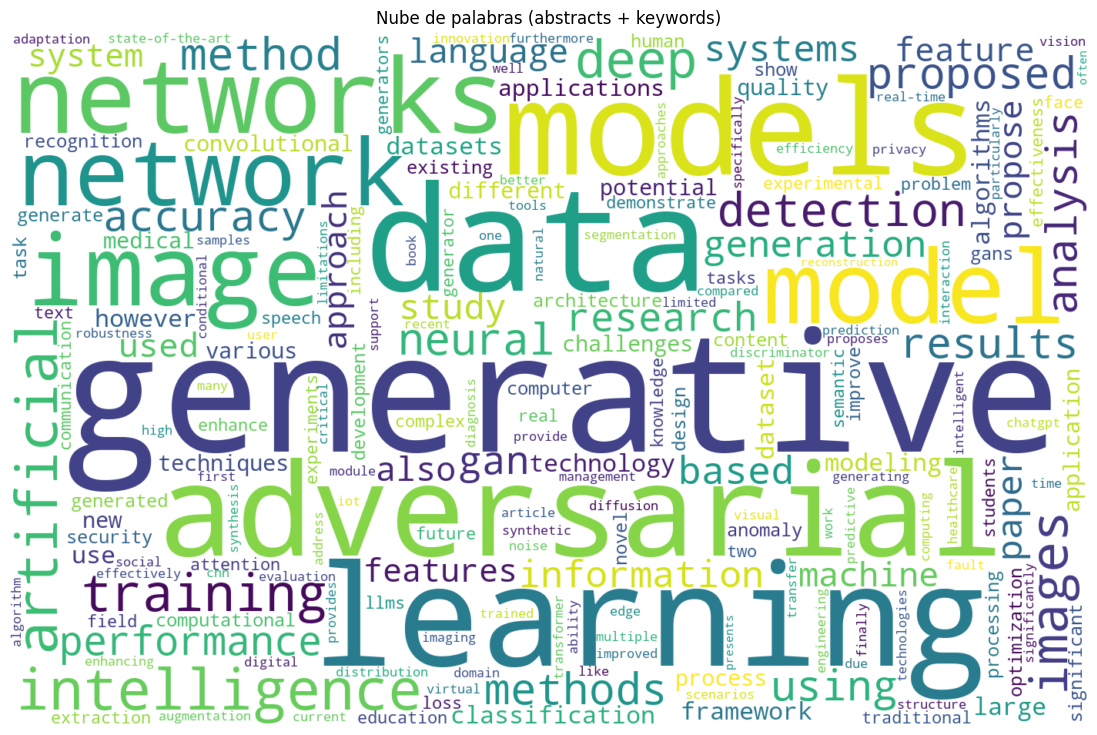

Nube guardada en outputs\nube_palabras.png
PDF generado en outputs\nube_palabras.pdf


In [11]:
# Generar nube de palabras y guardar PNG/PDF
import json
import re
from collections import Counter
from pathlib import Path

OUT_DIR = Path('outputs')
OUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR = Path('data')
records_path = DATA_DIR / 'records.csv'
freq_path = DATA_DIR / 'frequencies.json'

if not records_path.exists():
    raise FileNotFoundError(f"No se encontró {records_path}. Ejecuta la celda de parseo antes.")

import pandas as pd
records = pd.read_csv(records_path, dtype=str).fillna('')

# Construir corpus: abstracts + keywords
texts = (records['abstract'].fillna('') + ' ' + records.get('keywords', '').fillna(''))

# Tokenización básica y limpieza
word_re = re.compile(r"\b[\w'-]{3,}\b", flags=re.UNICODE)

# Stopwords: intentar usar NLTK, si no está simplemente usar una lista corta
try:
    import nltk
    from nltk.corpus import stopwords
    try:
        stopwords.words('spanish')
    except Exception:
        nltk.download('stopwords')
    stop_es = set(stopwords.words('spanish'))
    stop_en = set(stopwords.words('english'))
    STOP = stop_es | stop_en
except Exception:
    STOP = set([ 'the','and','for','with','that','this','from','using','use','research','study','method','results','analysis','based','data','paper' ])

counter = Counter()
for txt in texts:
    for w in word_re.findall(str(txt).lower()):
        if w in STOP:
            continue
        if w.isdigit():
            continue
        counter[w] += 1

# Guardar frecuencias (dinámico)
freq_payload = {'total_terms': sum(counter.values()), 'terms': dict(counter)}
with open(freq_path, 'w', encoding='utf-8') as f:
    json.dump(freq_payload, f, ensure_ascii=False, indent=2)

# Intentar crear nube con wordcloud; si no está, crear gráfico de barras con matplotlib
out_png = OUT_DIR / 'nube_palabras.png'
out_pdf = OUT_DIR / 'nube_palabras.pdf'

# helper para mostrar imágenes inline (Pillow -> IPython)
from IPython.display import display

try:
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt

    wc = WordCloud(width=1400, height=900, background_color='white', collocations=False).generate_from_frequencies(counter)

    # Mostrar en notebook
    plt.figure(figsize=(14,9))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nube de palabras (abstracts + keywords)')
    plt.show()

    # Guardar como PNG
    wc.to_file(str(out_png))
    print('Nube guardada en', out_png)

    # Convertir PNG -> PDF con Pillow
    try:
        from PIL import Image
        im = Image.open(out_png).convert('RGB')
        im.save(out_pdf, 'PDF', resolution=300)
        print('PDF generado en', out_pdf)
    except Exception as e:
        print('No se pudo convertir PNG a PDF con Pillow:', e)

except Exception as e:
    print('wordcloud no instalado o error al generar nube:', e)
    # fallback: barras
    import matplotlib.pyplot as plt
    top = counter.most_common(50)
    if not top:
        print('No hay términos para generar la nube/bar chart.')
    else:
        words, freqs = zip(*top)
        plt.figure(figsize=(12,8))
        plt.barh(range(len(words))[::-1], freqs[::-1], color='tab:blue')
        plt.yticks(range(len(words)), [w for w in words][::-1])
        plt.title('Top 50 términos (abstracts + keywords)')
        plt.tight_layout()
        plt.show()
        plt.savefig(out_png, dpi=200)
        print('Bar chart guardado en', out_png)
        try:
            from PIL import Image
            im = Image.open(out_png).convert('RGB')
            im.save(out_pdf, 'PDF', resolution=300)
            print('PDF generado en', out_pdf)
        except Exception as e2:
            print('No se pudo convertir PNG a PDF con Pillow:', e2)


## Enriquecimiento y normalización de `venue` (revistas/conferencias)

Esta celda consulta Crossref (si hay DOI) para obtener `container-title` e `ISSN` y crea una clave canónica `venue_key` (preferiblemente `ISSN:xxxx` si existe, sino título normalizado). Guarda `data/venue_lookup.csv` para revisión manual y añade `venue_key` a `data/records.csv`.


In [12]:
# Enriquecer venues usando Crossref y crear venue_lookup + actualizar records.csv
import requests, time, re, json
from pathlib import Path
import pandas as pd

DATA_DIR = Path('data')
records_path = DATA_DIR / 'records.csv'
venue_lookup_path = DATA_DIR / 'venue_lookup.csv'
venue_cache_path = DATA_DIR / 'venue_cache.json'

if not records_path.exists():
    raise FileNotFoundError(f"No se encontró {records_path}. Ejecuta la celda de parseo antes.")

# cargar registros
records = pd.read_csv(records_path, dtype=str).fillna('')

# helper: normalizar títulos
def normalize_title(t):
    if not t or pd.isna(t):
        return ''
    s = str(t).lower()
    s = re.sub(r"\\(.*?\\)", "", s)            # quitar paréntesis y su contenido
    s = re.sub(r"[^a-z0-9\\s]", ' ', s)
    s = re.sub(r"\\s+", ' ', s).strip()
    # reemplazos sencillos comunes
    reps = {
        'transactions on': 'trans',
        'journal of': '',
        'ieee ': 'ieee ',
        'proceedings of the ': '',
    }
    for k,v in reps.items():
        s = s.replace(k, v)
    return s

# función para consultar Crossref por DOI y devolver container-title e ISSN
def crossref_container(doi, email=''):
    if not doi or pd.isna(doi):
        return {}
    doi_clean = str(doi).replace('doi:', '').strip()
    url = f'https://api.crossref.org/works/{requests.utils.requote_uri(doi_clean)}'
    headers = {'User-Agent': f'proyecto-analisis-algoritmos (mailto:{email})' if email else 'proyecto-analisis-algoritmos'}
    try:
        r = requests.get(url, headers=headers, timeout=20)
        if r.status_code != 200:
            return {}
        msg = r.json().get('message', {})
        container = msg.get('container-title') or []
        issns = msg.get('ISSN') or msg.get('issn') or []
        publisher = msg.get('publisher','')
        return {
            'container_title': container[0] if container else '',
            'issn': issns[0] if issns else '',
            'publisher': publisher
        }
    except Exception as e:
        return {}

# Cargar cache previa si existe
venue_cache = {}
if venue_cache_path.exists():
    try:
        with open(venue_cache_path, 'r', encoding='utf-8') as f:
            venue_cache = json.load(f)
    except Exception:
        venue_cache = {}

# Recolectar todos los valores raw de venue
raw_venues = records['venue'].fillna('').map(str).str.strip().unique().tolist()
print(f'Found {len(raw_venues)} unique raw venue strings')

# Para cada raw venue, si no está en cache, intentar enriquecer usando un DOI de ejemplo
for raw in raw_venues:
    if raw in venue_cache:
        continue
    entry = {'raw': raw, 'doi_sample': '', 'container_title': '', 'issn': '', 'publisher': '', 'venue_key': ''}
    # buscar DOI de ejemplo en registros con este venue
    sample = records[records['venue'].fillna('').str.strip() == raw]['doi'].dropna().astype(str)
    doi_sample = sample.iloc[0] if not sample.empty else ''
    entry['doi_sample'] = doi_sample
    if doi_sample:
        meta = crossref_container(doi_sample)
        # pause para respetar rate limit
        time.sleep(0.8)
        if meta:
            entry['container_title'] = meta.get('container_title','')
            entry['issn'] = meta.get('issn','')
            entry['publisher'] = meta.get('publisher','')
            if entry['issn']:
                entry['venue_key'] = f'ISSN:{entry["issn"]}'
            elif entry['container_title']:
                entry['venue_key'] = normalize_title(entry['container_title'])
            else:
                entry['venue_key'] = normalize_title(raw)
        else:
            entry['venue_key'] = normalize_title(raw)
    else:
        # sin DOI de muestra: solo normalizar raw
        entry['venue_key'] = normalize_title(raw)
    venue_cache[raw] = entry

# guardar cache en JSON y CSV para revisión
with open(venue_cache_path, 'w', encoding='utf-8') as f:
    json.dump(venue_cache, f, ensure_ascii=False, indent=2)

venue_df = pd.DataFrame.from_records(list(venue_cache.values()))
venue_df.to_csv(venue_lookup_path, index=False, encoding='utf-8')
print('Venue lookup guardado en', venue_lookup_path)

# Aplicar mapping a records para crear columna venue_key
map_dict = {r['raw']: r['venue_key'] for r in venue_df.to_dict(orient='records')}
records['venue_key'] = records['venue'].fillna('').map(map_dict).fillna(records['venue'].apply(normalize_title))

# Guardar registros enriquecidos (respaldo y overwrite)
records.to_csv(DATA_DIR / 'records_with_venue_key.csv', index=False, encoding='utf-8')
records.to_csv(records_path, index=False, encoding='utf-8')
print('records.csv actualizado con columna venue_key y guardado en data/records_with_venue_key.csv')


Found 355 unique raw venue strings
Venue lookup guardado en data\venue_lookup.csv
Venue lookup guardado en data\venue_lookup.csv
records.csv actualizado con columna venue_key y guardado en data/records_with_venue_key.csv
records.csv actualizado con columna venue_key y guardado en data/records_with_venue_key.csv


In [19]:
# Diagnóstico y mejora automática para venues genéricos (IEEE, Taylor, ScienceDirect, etc.)
# - Intenta hasta N DOIs por raw venue para recuperar container-title/ISSN
# - Agrupa variantes con fuzzy matching si falta ISSN
# - Guarda venue_cache/venue_lookup.csv y actualiza records.csv

import pandas as pd
import json
import time
import requests
import re
from pathlib import Path

DATA_DIR = Path('data')
records_path = DATA_DIR / 'records.csv'
venue_lookup_path = DATA_DIR / 'venue_lookup.csv'
venue_cache_path = DATA_DIR / 'venue_cache.json'

if not records_path.exists():
    raise FileNotFoundError(f"No se encontró {records_path}. Ejecuta la celda de parseo antes.")

records = pd.read_csv(records_path, dtype=str).fillna('')

# Cargar cache existente
venue_cache = {}
if venue_cache_path.exists():
    try:
        with open(venue_cache_path, 'r', encoding='utf-8') as f:
            venue_cache = json.load(f)
    except Exception:
        venue_cache = {}

# Recolectar raw venues y contaje
raw_venues = records['venue'].fillna('').map(str).str.strip()
venue_counts = raw_venues.value_counts()
raw_list = venue_counts.index.tolist()
print(f'Raw venues únicos: {len(raw_list)}. Ejemplo top 10: {raw_list[:10]}')

# helper: normalizar título (coincide con la función anterior)
import re

def normalize_title(t):
    if not t or pd.isna(t):
        return ''
    s = str(t).lower()
    s = re.sub(r"\(.*?\)", "", s)
    s = re.sub(r"[^a-z0-9\s]", ' ', s)
    s = re.sub(r"\s+", ' ', s).strip()
    reps = {'transactions on': 'trans', 'journal of': '', 'proceedings of the ': ''}
    for k,v in reps.items():
        s = s.replace(k, v)
    return s

# Crossref helper (como antes)
def crossref_container(doi, email=''):
    if not doi:
        return {}
    doi_clean = str(doi).replace('doi:', '').strip()
    url = f'https://api.crossref.org/works/{requests.utils.requote_uri(doi_clean)}'
    headers = {'User-Agent': f'proyecto-analisis-algoritmos (mailto:{email})' if email else 'proyecto-analisis-algoritmos'}
    try:
        r = requests.get(url, headers=headers, timeout=20)
        if r.status_code != 200:
            return {}
        msg = r.json().get('message', {})
        container = msg.get('container-title') or []
        issns = msg.get('ISSN') or msg.get('issn') or []
        publisher = msg.get('publisher','')
        return {'container_title': container[0] if container else '', 'issn': issns[0] if issns else '', 'publisher': publisher}
    except Exception:
        return {}

# Para venues que parezcan demasiado genéricos, intentaremos enrich con hasta N DOIs
GENERIC_KEYWORDS = ['ieee', 'sciencedirect', 'taylor', 'elsvier', 'elsevier', 'springer', 'acm', 'mdpi']

def looks_generic(s):
    if not s or str(s).strip() == '':
        return True
    s2 = str(s).lower()
    # si es corto y sin detalles, probablemente genérico
    if len(s2) <= 6:
        return True
    for k in GENERIC_KEYWORDS:
        if k in s2:
            return True
    return False

# Reintentar enrichment con varios DOIs por raw venue
MAX_DOIS_PER_VENUE = 5
PAUSE = 0.6
updated = 0
for raw in raw_list:
    # skip if already have an ISSN in cache
    cached = venue_cache.get(raw, {})
    if cached.get('issn'):
        continue
    # only try re-enrich if looks generic OR venue_key is too short
    if not looks_generic(raw):
        continue
    # obtener hasta N DOIs de ejemplo con ese raw venue
    sample_dois = records.loc[records['venue'].fillna('').str.strip() == raw, 'doi'].dropna().astype(str).unique().tolist()
    sample_dois = [d for d in sample_dois if d.strip()]
    if not sample_dois:
        # nada que intentar
        continue
    sample_dois = sample_dois[:MAX_DOIS_PER_VENUE]
    found = False
    entry = cached if cached else {'raw': raw, 'doi_sample': sample_dois[0] if sample_dois else '', 'container_title': '', 'issn': '', 'publisher': '', 'venue_key': ''}
    for doi in sample_dois:
        meta = crossref_container(doi)
        time.sleep(PAUSE)
        if not meta:
            continue
        if meta.get('issn') or meta.get('container_title'):
            entry['doi_sample'] = doi if not entry.get('doi_sample') else entry['doi_sample']
            entry['container_title'] = meta.get('container_title','') or entry.get('container_title','')
            entry['issn'] = meta.get('issn','') or entry.get('issn','')
            entry['publisher'] = meta.get('publisher','') or entry.get('publisher','')
            # prefer ISSN key
            if entry.get('issn'):
                entry['venue_key'] = f"ISSN:{entry['issn']}"
            else:
                entry['venue_key'] = normalize_title(entry.get('container_title') or raw)
            found = True
            break
    if found:
        venue_cache[raw] = entry
        updated += 1

print(f'Venue re-enrichment attempts updated entries: {updated}')

# Si aún existen muchos raw venues no mapeados, aplicar clustering fuzzy sobre normalized titles
# Cargar existing canonical list
venue_df = pd.DataFrame.from_records(list(venue_cache.values())) if venue_cache else pd.DataFrame(columns=['raw','doi_sample','container_title','issn','publisher','venue_key'])

# preparar lista de canonicals y normals
venue_df['norm_raw'] = venue_df['raw'].apply(normalize_title)
venue_df['norm_key'] = venue_df['venue_key'].fillna('').apply(normalize_title)

# crear conjunto de claves canonicas conocidas
canonicals = set(venue_df[venue_df['venue_key'].notna()]['venue_key'].unique().tolist())

# fallback fuzzy using rapidfuzz or difflib
try:
    from rapidfuzz import process as rf_process
    def fuzzy_match(query, choices, limit=3):
        if not query:
            return []
        res = rf_process.extract(query, choices, limit=limit)
        return [r[0] for r in res if r[1] >= 80]
except Exception:
    import difflib
    def fuzzy_match(query, choices, limit=3):
        if not query:
            return []
        res = difflib.get_close_matches(query, choices, n=limit, cutoff=0.8)
        return res

# Build normalized mapping from norm_key -> canonical
norm_to_canonical = {}
for _, row in venue_df.dropna(subset=['venue_key']).iterrows():
    nk = normalize_title(str(row['venue_key']))
    if nk:
        norm_to_canonical[nk] = row['venue_key']

# For entries without a solid venue_key, try to assign a canonical by fuzzy matching norm_raw to existing norm keys
assigned = 0
for idx, row in venue_df.iterrows():
    if row.get('venue_key'):
        continue
    nraw = row.get('norm_raw','')
    if not nraw:
        continue
    candidates = fuzzy_match(nraw, list(norm_to_canonical.keys()), limit=2)
    if candidates:
        chosen = candidates[0]
        venue_df.at[idx,'venue_key'] = norm_to_canonical[chosen]
        assigned += 1

print(f'Assigned by fuzzy clustering: {assigned}')

# Merge back any updates to venue_cache
for _, r in venue_df.iterrows():
    raw = r['raw']
    venue_cache[raw] = r.dropna().to_dict()

# Guardar cache y CSV
with open(venue_cache_path, 'w', encoding='utf-8') as f:
    json.dump(venue_cache, f, ensure_ascii=False, indent=2)

venue_df_out = pd.DataFrame.from_records(list(venue_cache.values()))
venue_df_out.to_csv(venue_lookup_path, index=False, encoding='utf-8')

# Aplicar mapping a records para crear columna venue_key
map_dict = {r['raw']: r.get('venue_key','') for r in venue_df_out.to_dict(orient='records')}
records['venue_key'] = records['venue'].fillna('').map(map_dict).fillna(records['venue'].apply(normalize_title))
records.to_csv(DATA_DIR / 'records_with_venue_key.csv', index=False, encoding='utf-8')
records.to_csv(records_path, index=False, encoding='utf-8')

print('Venue lookup actualizado y records.csv actualizado con venue_key. Revisa data/venue_lookup.csv para curación manual.')

# Mostrar top 60 mappings y counts para inspección rápida
preview = venue_df_out.copy()
preview['count'] = preview['raw'].map(venue_counts).fillna(0).astype(int)
preview = preview.sort_values('count', ascending=False).head(60)
print('Top mappings (raw, venue_key, count):')
print(preview[['raw','venue_key','container_title','issn','count']].to_string(index=False))


Raw venues únicos: 355. Ejemplo top 10: ['IEEE Access', 'IEEE Transactions on Artificial Intelligence', 'IEEE Network', 'Generative Artificial Intelligence for Biomedical and Smart Health Informatics', 'AI Revolution: Mastering AI for Personal and Organizational Growth', 'IEEE Internet of Things Journal', 'IEEE Transactions on Pattern Analysis and Machine Intelligence', 'IEEE Transactions on Neural Networks and Learning Systems', 'IEEE Journal of Biomedical and Health Informatics', '2024 8th Asian Conference on Artificial Intelligence Technology (ACAIT)']
Venue re-enrichment attempts updated entries: 99
Assigned by fuzzy clustering: 0
Venue re-enrichment attempts updated entries: 99
Assigned by fuzzy clustering: 0
Venue lookup actualizado y records.csv actualizado con venue_key. Revisa data/venue_lookup.csv para curación manual.
Top mappings (raw, venue_key, count):
                                                                                                                         

In [20]:
# Crear columna `publisher_key` en records usando `data/venue_lookup.csv` y heurísticas simples
import pandas as pd
from pathlib import Path

DATA_DIR = Path('data')
records_path = DATA_DIR / 'records.csv'
venue_lookup_path = DATA_DIR / 'venue_lookup.csv'

if not records_path.exists():
    raise FileNotFoundError(f"No se encontró {records_path}. Ejecuta la celda de parseo antes.")

records = pd.read_csv(records_path, dtype=str).fillna('')

if venue_lookup_path.exists():
    vl = pd.read_csv(venue_lookup_path, dtype=str).fillna('')
else:
    vl = pd.DataFrame(columns=['raw','doi_sample','container_title','issn','publisher','venue_key'])

# Mapas rápidos
raw_to_publisher = {}
issn_to_publisher = {}
for _, r in vl.iterrows():
    raw = str(r.get('raw','')).strip()
    pub = (r.get('publisher') or '').strip()
    issn = (r.get('issn') or '').strip()
    vkey = (r.get('venue_key') or '').strip()
    if pub:
        raw_to_publisher[raw] = pub
    if issn and pub:
        issn_to_publisher[f'ISSN:{issn}'] = pub
    # if no publisher but venue_key looks like ISSN:..., map that key to container_title as fallback
    if vkey and not pub and r.get('container_title'):
        raw_to_publisher[raw] = r.get('container_title')

# heurística por palabras clave
def guess_publisher_from_raw(raw):
    s = (raw or '').lower()
    if 'ieee' in s:
        return 'IEEE'
    if 'sciencedirect' in s or 'elsevier' in s:
        return 'Elsevier/ScienceDirect'
    if 'taylor' in s:
        return 'Taylor & Francis'
    if 'springer' in s:
        return 'Springer'
    if 'acm' in s:
        return 'ACM'
    if 'mdpi' in s:
        return 'MDPI'
    if 'wiley' in s:
        return 'Wiley'
    return ''

# función para obtener publisher_key por fila
import re

def get_publisher_key(row):
    vk = (row.get('venue_key') or '').strip()
    raw = (row.get('venue') or '').strip()
    # 1) por ISSN clave
    if vk and vk in issn_to_publisher:
        return issn_to_publisher[vk]
    # 2) por raw exacto
    if raw in raw_to_publisher and raw_to_publisher[raw]:
        return raw_to_publisher[raw]
    # 3) buscar coincidencia parcial en raw_to_publisher claves
    for k,v in raw_to_publisher.items():
        if k and k.lower() in raw.lower():
            return v
    # 4) heurística por palabras clave
    g = guess_publisher_from_raw(raw)
    if g:
        return g
    # 5) intentar derivar del venue_key (si no es ISSN)
    if vk:
        return vk
    return 'Otros'

records['publisher_key'] = records.apply(get_publisher_key, axis=1)

# Guardar copia y actualizar records.csv
records.to_csv(DATA_DIR / 'records_with_publisher_key.csv', index=False, encoding='utf-8')
records.to_csv(records_path, index=False, encoding='utf-8')

print('Añadida columna publisher_key y guardado en data/records_with_publisher_key.csv (y actualizado data/records.csv)')
print('\nTop publishers:')
print(records['publisher_key'].value_counts().head(30).to_string())


Añadida columna publisher_key y guardado en data/records_with_publisher_key.csv (y actualizado data/records.csv)

Top publishers:
publisher_key
IEEE                                                                                                                       304
Institute of Electrical and Electronics Engineers (IEEE)                                                                   151
Wiley                                                                                                                       12
Institution of Engineering and Technology (IET)                                                                              7
ai revolution  mastering ai for personal and organizational growth                                                           5
toward artificial general intelligence  deep learning  neural networks  generative ai                                        3
generative ai  navigating the course to the artificial general intelligence future            

In [21]:
# Línea temporal agrupada por editor/publisher (usa `publisher_key`) — ejecuta después de crear `publisher_key`
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from pathlib import Path
from itertools import cycle

OUT_DIR = Path('outputs')
OUT_DIR.mkdir(parents=True, exist_ok=True)

records = pd.read_csv('data/records.csv', dtype=str).fillna('')
if 'publisher_key' not in records.columns:
    raise ValueError('No se encontró la columna publisher_key en data/records.csv. Ejecuta la celda que crea publisher_key primero.')

# preparar años
records['year'] = pd.to_numeric(records['year'], errors='coerce').astype('Int64')
records = records[records['year'].notna()].copy()
records['year'] = records['year'].astype(int)
YEARS = list(range(records['year'].min(), records['year'].max() + 1))

# parámetros
TOP_N = 10
venue_col = 'publisher_key'

# calcular top publishers
venue_counts = records[venue_col].replace('', 'Sin publisher').value_counts()
top_venues = venue_counts.nlargest(TOP_N).index.tolist()

# marcar Otros
records['venue_group'] = records[venue_col].where(records[venue_col].isin(top_venues), other='Otros')

# pivot
pivot = records.groupby(['year','venue_group']).size().unstack(fill_value=0).reindex(index=YEARS, fill_value=0).sort_index()

# total
total_year = records.groupby('year').size().reindex(index=YEARS, fill_value=0)

# ordenar trazas por suma
col_totals = pivot.sum(axis=0).sort_values(ascending=False)
cols_sorted = [c for c in col_totals.index if c != 'Otros']
if 'Otros' in pivot.columns:
    cols_sorted = [c for c in cols_sorted if c != 'Otros'] + (['Otros'] if 'Otros' in pivot.columns else [])

# paleta
palette = px.colors.qualitative.Plotly
color_cycle = cycle(palette)

# construir figura
fig = go.Figure()
fig.add_trace(go.Scatter(x=YEARS, y=total_year.values, mode='lines+markers', name='Total publicaciones', line=dict(width=4,color='black')))
for col in cols_sorted:
    color = next(color_cycle)
    label = str(col)
    short = label if len(label) <= 80 else label[:77] + '...'
    fig.add_trace(go.Scatter(x=YEARS, y=pivot[col].reindex(YEARS, fill_value=0).values, mode='lines+markers', name=short, hovertemplate='%{x}<br>' + label + ': %{y}<extra></extra>', line=dict(width=2,color=color)))

fig.update_layout(title=f'Línea temporal por editor (top {TOP_N} publishers + Otros)', xaxis_title='Año', yaxis_title='Número de publicaciones', width=1200, height=600, legend=dict(orientation='v', x=1.02, y=1), margin=dict(r=300,t=80))

if len(YEARS) > 15:
    fig.update_xaxes(tickangle=-45, dtick=1)
else:
    fig.update_xaxes(dtick=1)

fig.show()

# guardar
out_png = OUT_DIR / 'linea_tiempo_by_publisher.png'
out_pdf = OUT_DIR / 'linea_tiempo_by_publisher.pdf'

saved = False
try:
    fig.write_image(str(out_png), format='png', engine='kaleido', width=1200, height=600, scale=2)
    try:
        from PIL import Image
        im = Image.open(out_png).convert('RGB')
        im.save(out_pdf, 'PDF', resolution=300)
        print('Guardado (PNG -> PDF):', out_png, out_pdf)
        saved = True
    except Exception as e:
        print('PNG guardado pero fallo conversión a PDF por Pillow:', e)
        saved = True
except Exception as e:
    print('No se pudo exportar PNG con kaleido:', e)

if not saved:
    try:
        fig.write_html(OUT_DIR / 'linea_tiempo_by_publisher.html')
        print('Exportado a HTML interactivo como fallback')
    except Exception as e:
        print('Falló exportación de la figura:', e)

print('Trazas mostradas (incluye Total):', len(cols_sorted) + 1)


C:\Users\camil\AppData\Local\Temp\ipykernel_14040\4242849268.py:72: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




Guardado (PNG -> PDF): outputs\linea_tiempo_by_publisher.png outputs\linea_tiempo_by_publisher.pdf
Trazas mostradas (incluye Total): 12


## Línea temporal: publicaciones por año y por revista

Genera una gráfica de líneas con el total de publicaciones por año y trazas separadas para las revistas (top-N). Guarda `outputs/linea_tiempo.png` y `outputs/linea_tiempo.pdf`.


In [22]:
# Mejora: timeline más legible (top N + Otros), usar `venue_key` si existe, leyenda a la derecha, exportación robusta
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from pathlib import Path
from itertools import cycle

OUT_DIR = Path('outputs')
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Cargar registros
records = pd.read_csv('data/records.csv', dtype=str).fillna('')
# Preferir venue_key (normalizada) si está disponible
venue_col = 'venue_key' if 'venue_key' in records.columns else 'venue'

# Convertir año a entero y filtrar
records['year'] = pd.to_numeric(records['year'], errors='coerce').astype('Int64')
records = records[records['year'].notna()].copy()
records['year'] = records['year'].astype(int)

# Parámetros
TOP_N = 12
MIN_YEAR = records['year'].min()
MAX_YEAR = records['year'].max()
YEARS = list(range(MIN_YEAR, MAX_YEAR + 1))

# Calcular top venues según la columna escogida
venue_counts = records[venue_col].replace('', 'Sin venue').value_counts()
top_venues = venue_counts.nlargest(TOP_N).index.tolist()

# Marcar "Otros" usando la columna canonical
records['venue_group'] = records[venue_col].where(records[venue_col].isin(top_venues), other='Otros')

# Pivot year x venue_group, asegurar años continuos
pivot = records.groupby(['year', 'venue_group']).size().unstack(fill_value=0).reindex(index=YEARS, fill_value=0).sort_index()

# Series con total por año (de todos los registros)
total_year = records.groupby('year').size().reindex(index=YEARS, fill_value=0)

# Ordenar las columnas (trazas) por suma total descendente para consistencia visual
col_totals = pivot.sum(axis=0).sort_values(ascending=False)
cols_sorted = [c for c in col_totals.index if c != 'Otros']
# si 'Otros' existe, lo ponemos al final
if 'Otros' in pivot.columns:
    cols_sorted = [c for c in cols_sorted if c != 'Otros'] + (['Otros'] if 'Otros' in pivot.columns else [])

# Preparar paleta de colores (asegurar suficiente variedad)
palette = px.colors.qualitative.Plotly
color_cycle = cycle(palette)

# Construir figura
fig = go.Figure()
# traza del total (primera trazas para destacarla)
fig.add_trace(go.Scatter(x=YEARS, y=total_year.values,
                         mode='lines+markers', name='Total publicaciones',
                         line=dict(width=4, color='black'), marker=dict(size=6)))

# Añadir trazas en orden: las top revistas (cols_sorted) y luego Otros si está
for col in cols_sorted:
    # elegir color de la paleta
    color = next(color_cycle)
    # acortar nombre largo para la leyenda pero mantener nombre completo en hover (si es necesario)
    label = str(col)
    if len(label) > 80:
        short = label[:77] + '...'
    else:
        short = label
    fig.add_trace(go.Scatter(x=YEARS, y=pivot[col].reindex(YEARS, fill_value=0).values,
                             mode='lines+markers', name=short,
                             hovertemplate='%{x}<br>' + label + ': %{y}<extra></extra>',
                             line=dict(width=2, color=color), marker=dict(size=5)))

fig.update_layout(
    title=f'Línea temporal: publicaciones por año (top {TOP_N} revistas + Otros)',
    xaxis_title='Año',
    yaxis_title='Número de publicaciones',
    width=1400, height=600,
    legend=dict(orientation='v', x=1.02, y=1, font=dict(size=10)),
    margin=dict(r=360, t=80),  # espacio para la leyenda a la derecha y título
)

# Mejoras visuales: eje X con ticks por año y rotación si muchos años
if len(YEARS) > 15:
    fig.update_xaxes(tickangle= -45, dtick=1)
else:
    fig.update_xaxes(dtick=1)

fig.show()

# Guardar high-res PNG y convertir a PDF (kaleido + Pillow) con fallback a HTML
out_png = OUT_DIR / 'linea_tiempo_improved.png'
out_pdf = OUT_DIR / 'linea_tiempo_improved.pdf'
out_html = OUT_DIR / 'linea_tiempo_improved.html'

saved = False
try:
    # intentamos PNG (kaleido)
    fig.write_image(str(out_png), format='png', engine='kaleido', width=1400, height=600, scale=2)
    try:
        from PIL import Image
        im = Image.open(out_png).convert('RGB')
        im.save(out_pdf, 'PDF', resolution=300)
        print('Guardado (PNG -> PDF):', out_png, out_pdf)
        saved = True
    except Exception as e:
        print('PNG guardado pero fallo conversión a PDF por Pillow:', e)
        saved = True  # PNG sí está disponible
except Exception as e:
    print('No se pudo exportar PNG con kaleido:', e)

if not saved:
    try:
        # fallback: guardar HTML interactivo
        fig.write_html(str(out_html))
        print('Exportado a HTML interactivo en', out_html)
    except Exception as e:
        print('No se pudo exportar la figura (kaleido y HTML fallaron):', e)

print('Trazas mostradas:', len(cols_sorted) + 1, '(incluye Total)')


C:\Users\camil\AppData\Local\Temp\ipykernel_14040\3470777286.py:98: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




Guardado (PNG -> PDF): outputs\linea_tiempo_improved.png outputs\linea_tiempo_improved.pdf
Trazas mostradas: 14 (incluye Total)


## Combinar PDFs y generar informe final

Combina `mapa_paises.pdf`, `nube_palabras.pdf` y `linea_tiempo.pdf` en `outputs/requerimiento5_report.pdf`. Si no está disponible `PyPDF2`, muestra las rutas de los archivos para que puedas combinarlos manualmente.


In [14]:
# Combinar PDFs en un único informe
from pathlib import Path
OUT_DIR = Path('outputs')
files = [OUT_DIR / 'mapa_paises.pdf', OUT_DIR / 'nube_palabras.pdf', OUT_DIR / 'linea_tiempo.pdf']
available = [f for f in files if f.exists()]

if not available:
    print('No se encontraron los PDFs esperados en outputs/. Asegúrate de ejecutar las celdas de generación antes.')
    for f in files:
        print('-', f)
else:
    try:
        from PyPDF2 import PdfMerger
        merger = PdfMerger()
        for f in files:
            if f.exists():
                merger.append(str(f))
        out = OUT_DIR / 'requerimiento5_report.pdf'
        merger.write(str(out))
        merger.close()
        print('Informe combinado generado en', out)
    except Exception as e:
        print('No se pudo combinar con PyPDF2:', e)
        print('Archivos disponibles:')
        for f in available:
            print('-', f)
        print('Puedes combinarlos manualmente o instalar PyPDF2 (pip install PyPDF2)')


Informe combinado generado en outputs\requerimiento5_report.pdf
